In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yotam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Packages 

In [3]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout, Bidirectional,\
SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
#from keras.layers.embeddings import Embedding
from tensorflow.keras import layers, initializers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from nltk.stem.porter import *
from nltk import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))

%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

# function to plot train and validation over epochs
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [5]:
# function to plot confussion matrix
def plot_confussion_matrix(labels, predictions, classes, figsize = 3):
    
    con_mat = tf.math.confusion_matrix(labels, predictions).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 3)

    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)

    figure = plt.figure(figsize=(figsize, figsize))
    sns.heatmap(con_mat_df
                , annot=True
                , xticklabels=classes
                , yticklabels=classes
                #, cmap=plt.cm.Blues
                )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlim(-0.0, len(classes))
    plt.ylim(len(classes), -0.0)
    plt.show()

In [6]:
df_2 = pd.read_csv("training.1600000.processed.noemoticon.csv")
df_2

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


## Load data 

In [7]:
filename = "training.1600000.processed.noemoticon.csv"
#filename = "training_data\\hate_related.csv"
df = pd.read_csv(filename
                 , encoding = 'latin-1'#'utf-8'
                 , delimiter = ','
                 , index_col = False
                 , header = 1
                 , usecols = [0, 5]
                 , names = ['label', "text"]
)
print(df.shape)
df

(1599998, 2)


,label,text
0,0,@Kenichan I dived many times for the ball. Man...
1,0,my whole body feels itchy and like its on fire
2,0,"@nationwideclass no, it's not behaving at all...."
3,0,@Kwesidei not the whole crew
4,0,Need a hug
...,...,...
1599993,4,Just woke up. Having no school is the best fee...
1599994,4,TheWDB.com - Very cool to hear old Walt interv...
1599995,4,Are you ready for your MoJo Makeover? Ask me f...
1599996,4,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
#Reduce rows only to 10%

total = 1600000
Rows= total*0.10
print(type(Rows))
Rows = int(Rows)
df = df.sample(n=Rows, random_state=1)
df

<class 'float'>


,label,text
1147373,4,@seekzpeace nite
1520499,4,@Waisybabu I am glad one of us got it.
118016,0,@jboyd2012 well then again you dont tell me an...
1036369,4,Just finished recording a song w/ Allecia Clem...
163848,0,: nothing to do
...,...,...
352814,0,Rainy days make me so unmotivated. I know the...
392510,0,@backblocks I'm good. Recovering from last nig...
301301,0,@TONYROCK we were supposed to go there together
734014,0,So damn hot...i cannot conc on my studies at a...


In [9]:

row_df = df.shape[0]
Matriz= df.to_numpy()

for i in range(row_df):
    
    if Matriz[i,0]==0:
        Matriz[i,0]="negative"
        
    if Matriz[i,0]==2:
        Matriz[i,0]="neutral"
        
    if Matriz[i,0]==4:
        Matriz[i,0]="positive"

print(Matriz)
df = pd.DataFrame(Matriz[ :,:])
df.columns = ['label', 'text']
df 
    

[['positive' '@seekzpeace nite ']
 ['positive' '@Waisybabu I am glad one of us got it. ']
 ['negative'
  '@jboyd2012 well then again you dont tell me anything anymore!  but ok...']
 ...
 ['negative' '@TONYROCK we were supposed to go there together ']
 ['negative'
  'So damn hot...i cannot conc on my studies at all  - http://tweet.sg']
 ['positive'
  'off to dancing for an hour then shopping &amp; then marathon!! ']]


,label,text
0,positive,@seekzpeace nite
1,positive,@Waisybabu I am glad one of us got it.
2,negative,@jboyd2012 well then again you dont tell me an...
3,positive,Just finished recording a song w/ Allecia Clem...
4,negative,: nothing to do
...,...,...
159995,negative,Rainy days make me so unmotivated. I know the...
159996,negative,@backblocks I'm good. Recovering from last nig...
159997,negative,@TONYROCK we were supposed to go there together
159998,negative,So damn hot...i cannot conc on my studies at a...


positive    80019
negative    79981
Name: label, dtype: int64
original label type :<class 'str'>


<AxesSubplot:xlabel='unique_values'>

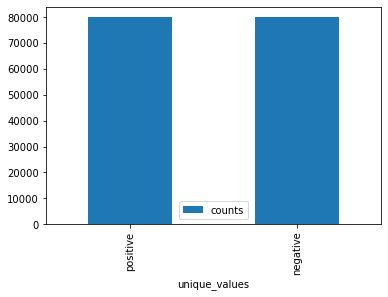

In [10]:
#Graph to see the number of times each label appear 
def get_list_counts(df, feature, pandas = False):
    df = df.copy(deep=True)
    x = df[feature].value_counts()
    if pandas:
        x = x.rename_axis('unique_values').reset_index(name='counts')
    return x

print(df['label'].value_counts())
df.head()

# change labels if not text
print('original label type :' + str(type(df.label[0])))
if type(df.label[0]) != str:
    df.label = df.label.astype(str)
    print('label type changed to :' + str(type(df.label[0])))
    
# plpot label distirbution
label_count = get_list_counts(df, 'label', pandas = True)
label_count.set_index('unique_values').plot(kind='bar')

We can see an equivalent quantity of values from positive and negative 

## Experimental parameters

In [11]:
epochs = 10 #numeros de iteraciones de la red neuronal
batch_size = 524 #es como particiono el dataset para meterlo a la red neuronal, es decir cada vuelta metere 524 observaciones
#los anteriores no los toco

#Parametros de experimentacion:

vocab_size = 15000 # max tokens to be considered in vocabulary based on frequency. Puede ser un parametro de experimentacion. El tamaño del vocabulario
embedding_dim = 50 # embedding dimension. This is the word vector representation size. Puede ser 50,100,300. Esto se ve en el nombre del dataset glove.6B.50d.txt. si se quiere otro embedding se tiene que sacar del tfhub.dev                                 

max_length = 40 # tokens expected per each text. Maxima longitud que acepto a mis documentos para que todos aquellos tengan la misma dimension. En este caso, 40 palabras
# num_convolution = 5. No le paro a esto 
trunc_type = 'post' # in case of exceeding "max_length", then truncate the sequence. Aqui estoy diciendo que en la ultima capa de red neuronal tenga un maximo de 40 palabras
padding_type = 'post' # in case of not fulfilling "max_length", then add zeroes in the the sequence.
oov_tok = '<OOV>' # code for unseen tokens. Codigo para las palabras que no han sido encontradas en el vocabulario 

training_portion = .6
test_proportion = 0.2

#For padding in the beginning is pre 

## Shuffle and subsample data according to test_proportion 

In [12]:
df_train, df_test = np.split(df.sample(frac=1, random_state=1).reset_index(drop=True), [int((1-test_proportion)*len(df))])

print(df_train.shape)
print(df_test.shape)

(128000, 2)
(32000, 2)


## Preprocessing data 

Stemmization: is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma

Lemmanization: is the grouping together of different forms of the same word.

### 1.1 Cleaning the text 

In [13]:
pat1 = r'http[^ ]+' # pattern to remove links
pat2 = r'www.[^ ]+' # pattern to remove links
pat3 = '[^a-zA-Z]+' # pattern to remove numbers
pat4 = r"@[^ ]+" #pattern to remove username
pat = r'|'.join((pat1, pat2, pat3))


def get_clean_text(text):

    #text = text.lower() # lowercase
    text = re.sub(pat4, ' ', text) # remove username
    text = re.sub(pat, ' ', text) # remove pat
    text = [w for w in tok.tokenize(text) if not w in stop_words] # remove stop_words
    #text = [w for w in text if len(w)>1] # remove words with len <2
    
    #stemmization
    #stemmer = PorterStemmer()
    #text = [stemmer.stem(w) for w in text] 
    
    #lemmarization 
    #lemmatizer = nltk.stem.WordNetLemmatizer()
    #text = [lemmatizer.lemmatize(w) for w in text]
    text = (' '.join(text)).strip() # list to string
    return text

df_train['text_clean'] = [get_clean_text(t) for t in df_train['text']]

df_train.head(20)

,label,text,text_clean
0,positive,I love my new family!! So glad we are all toge...,I love new family So glad together
1,positive,@mmarinnaa: 21.30 is fine i need to study in ...,fine need study morning u come whenever u want
2,positive,@ChristianKnott stupid. Btw you're missing out...,stupid Btw missing Made chocolate covered pret...
3,negative,"@swear_bot Nah, I don't think I'll stop... I h...",Nah I think I stop I pretty fucking big issues
4,positive,@ work... Very busy and happy to see an old sc...,work Very busy happy see old school friend
5,negative,@RobPattzNews It is sad that RPattz barely ack...,It sad RPattz barely acknowledges fans anymore...
6,positive,does not know what i am doing here lol,know lol
7,positive,LMAO!! In honor of my mile 1/2 time of 14:56 t...,LMAO In honor mile time today WOO HOO
8,positive,"@heyGiANNA Lmao you just got one, relax chicka...",Lmao got one relax chicka And omg jackin twitt...
9,positive,@PinkyNKOTB hi I'm ok still not feeling great,hi I ok still feeling great


techniques use:

-remove links

-remove numbers 

-Convert to lowercase

-remove symbols like @, ?

-remove words that have length less than 2 

-remove stop words (this are words like a, the, in, is,are)

## Model 

### Split of trainning and validation 

In [14]:
y = df_train['label']
x = df_train['text_clean']

label_distinct = len(set(y)) # this might be use as a dynamic parameter for the cost function layer (number of output neurons)
print('Distinct categories in train set :' + str(label_distinct))

train_size = int(len(y) * training_portion)

x_train = x[0: train_size]
y_train = y[0: train_size]
x_val = x[train_size:]
y_val = y[train_size:]

print('x_train records :' + str(len(x_train)))
print('y_train records :' + str(len(y_train)))
print('x_val records :' + str(len(x_val)))
print('y_val records :' + str(len(y_val)))

Distinct categories in train set :2
x_train records :76800
y_train records :76800
x_val records :51200
y_val records :51200


### Tokenization:

In [15]:
label_tokenizer = Tokenizer() # Tokenizer is a functionality from tensorflow wich transforms words into numbers. Once a word
# has been converted to a number, every consecutive upcoming word already seen is converted to the same number
# This process is called tokenization
label_tokenizer.fit_on_texts(y_train) # fit will return a dictionary
label_index = label_tokenizer.word_index # save indexes for reverse transformation

# Tokenizer indexes from 1 to p, where p is number of categories.
# Is useful to substract 1 in order to start from 0 instead of 1. This way the final Dense layer doesnt need a dummy.
for k in label_index:
    label_index[k] -= 1
print('label_index' + str(label_index))

# As opposose to labels, Tokenizer for text has to be parametrized
tokenizer = Tokenizer(num_words = vocab_size # max words to be considered
                      , oov_token=oov_tok) #I want "OOV" in bracket to be used to for words that are not in the word index.
tokenizer.fit_on_texts(x_train) # fit will return a dictionary
word_index = tokenizer.word_index # save indexes for reverse transformation
print('____________________________________________________________')
print('This is an example for 5 tokens in the word_index :' + str(dict(list(word_index.items())[0:5])))

label_index{'negative': 0, 'positive': 1}
____________________________________________________________
This is an example for 5 tokens in the word_index :{'<OOV>': 1, 'i': 2, 'good': 3, 'day': 4, 'get': 5}


In [16]:
# Once the tokenizer has been fitted, we transform our actual data
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)

y_train_seq = np.array(y_train.map(label_index))#label_tokenizer.texts_to_sequences(y_train))
y_val_seq = np.array(y_val.map(label_index))#np.array(label_tokenizer.texts_to_sequences(y_val))

x_train_seq

[[2, 11, 28, 253, 63, 205, 543],
 [485, 35, 495, 38, 16, 60, 2228, 16, 29],
 [333, 418, 265, 127, 599, 1942, 7709, 59],
 [990, 2, 33, 2, 236, 2, 150, 570, 180, 1472],
 [12, 525, 330, 55, 23, 152, 73, 169],
 [25, 52, 13047, 1603, 1, 943, 277, 1573, 62, 770, 134, 688, 49],
 [19, 14],
 [464, 254, 3160, 2185, 15, 9, 860, 1574],
 [464, 13, 18, 1349, 10442, 76, 148, 1, 40, 331, 20, 10443, 89],
 [213, 2, 107, 24, 114, 44],
 [81, 189, 418, 1787, 1788, 1171, 5345, 150, 34, 1350, 5346, 4172, 55],
 [115, 62, 133, 4650, 2046, 2403, 2046],
 [41, 86, 912, 360, 479, 24, 2927],
 [81, 3431],
 [13048, 1, 691],
 [415, 1, 52, 4651, 521, 218, 52],
 [3, 242, 6898, 7710],
 [2, 35, 669],
 [495, 207, 495, 1428, 991],
 [90, 163, 10, 886],
 [232, 12, 223],
 [3970, 315, 366, 1017, 7711, 349, 1134],
 [299, 1393, 56, 281],
 [68, 1631],
 [544, 3771, 4967],
 [1, 2663, 3772, 160, 1005, 3043],
 [418, 60, 589, 6279, 8877, 1, 1222, 405],
 [3971, 202, 187, 9],
 [760, 5, 331, 98, 2, 33, 49],
 [221, 4173, 1789, 17, 992, 328

### Pad: To pad is to add zeroes to the sequence in order ot have same lenght in all sequences (observations).


In [17]:
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(x_val_pad)
x_val_pad[1]

[[ 928   76    2 ...    0    0    0]
 [  91  283 4375 ...    0    0    0]
 [  32    2    7 ...    0    0    0]
 ...
 [  71 2669    1 ...    0    0    0]
 [ 373 1458    1 ...    0    0    0]
 [   2   37  113 ...    0    0    0]]


array([  91,  283, 4375,  720,    9,    9,  500, 1680,   18,   45,   18,
        334,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [18]:
# This is an example of the transformation we have performed until now:
print('original text :' + str(x_train[0]))
print('______________________________________________________________')
print('tokenized text :' + str(x_train_seq[0]))
print('______________________________________________________________')
print('padded text :' + str(x_train_pad[0]))
print('______________________________________________________________')
print('original label :' + str(y_train[0]))
print('______________________________________________________________')
print('tokenized label :' + str(y_train_seq[0]))

original text :I love new family So glad together
______________________________________________________________
tokenized text :[2, 11, 28, 253, 63, 205, 543]
______________________________________________________________
padded text :[  2  11  28 253  63 205 543   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
______________________________________________________________
original label :positive
______________________________________________________________
tokenized label :1


### Embedding: Consiste en introducir a cada palabra un vector que la representara en las redes neuronales

In [19]:
#import pre_trained_embedding
#We will use an embedding layer from the Tensorflow Hub. Me sale definido el vector de cada palabra 
#Podemos ver es un vector de dimension 50

pre_trained_embedding = "glove.6B.50d.txt"

# transform embedding using tokenized indexes. This is, transform the embedded word into same 
# token your data had

embeddings_index = {}

#Abro el fichero 
f = open(pre_trained_embedding, encoding="utf8")
for line in f:
    values = line.split() # the actual vector representation
    word = values[0] # the original word
    # place vector representation in the value where "key" equals "word"
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items(): # for each word in word_index dictionary
    embedding_vector = embeddings_index.get(word)# capture vector reprsntation using "word" as key
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
print('This is the word representation for the word "hello"')
print('______________________________________________________________')
print(str(embeddings_index['hello']))

This is the word representation for the word "hello"
______________________________________________________________
[-0.38497   0.80092   0.064106 -0.28355  -0.026759 -0.34532  -0.64253
 -0.11729  -0.33257   0.55243  -0.087813  0.9035    0.47102   0.56657
  0.6985   -0.35229  -0.86542   0.90573   0.03576  -0.071705 -0.12327
  0.54923   0.47005   0.35572   1.2611   -0.67581  -0.94983   0.68666
  0.3871   -1.3492    0.63512   0.46416  -0.48814   0.83827  -0.9246
 -0.33722   0.53741  -1.0616   -0.081403 -0.67111   0.30923  -0.3923
 -0.55002  -0.68827   0.58049  -0.11626   0.013139 -0.57654   0.048833
  0.67204 ]


### Model 

In [21]:
len_word_index = len(word_index)
len_word_index

43501

In [22]:
#Defining the model 

def make_model(  bidirectional_layers = 1
               , bidirectional_dropout = 0.0
               , dense_layers = 1
               , dense_dropout = 0.0
               , lr = 1e-3
               , output_bias = None
               , verbose = 1):
    
    model = Sequential()
    
    #Esta capa es donde le pasare el numero de palabras que tengo, que al final viene representado por un numero 
    model.add(Embedding(input_dim = len_word_index + 1 # the entering token j (j its a number) 
        #finds it´s word representation in the j row, where rows are "len_word_index + 1".
                       , output_dim = embedding_dim # word representation dimension. Question
                       , weights = [embedding_matrix] # pretrained embedding
                       , input_length = max_length # Expected text size
                       , trainable = False)) # Trainable = True when embedding elegigble to change
    
    for i in range(0,bidirectional_layers):
        
        # return_sequences -> last bidirectional doesnt return requences
        return_sequences = ((bidirectional_layers - i) != 1)
        model.add(Bidirectional(LSTM(embedding_dim
                                 , activation = 'relu'
                                 , dropout = bidirectional_dropout # regularization 
                                 , recurrent_dropout = bidirectional_dropout # regularization
                                 , return_sequences = return_sequences))
                  )

    for i in range(0,dense_layers):
        model.add(Dense(embedding_dim, activation='relu')) # dense layers
        if dense_dropout != 0.0:
            model.add(Dropout(dense_dropout)) # regularization
            
    # bias the cost function
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'    
    
    model.add(Dense(label_distinct
                    , activation='softmax'
                    , bias_initializer = output_bias))    

    model.compile(loss = 'sparse_categorical_crossentropy' # return prob dist
                  , optimizer = Adam(lr) # classic classification optimizer
                  , metrics = ['accuracy'])
    if verbose:
        
        print('bidirectional_layers :' + str(bidirectional_layers))
        print('bidirectional_dropout :' + str(bidirectional_dropout))
        print('dense_layers :' + str(dense_layers))
        print('dense_dropout :' + str(dense_dropout))
        print('lr :' + str(lr))

        print(model.summary())
    
    return model

In [23]:
#implementation of the model 
model = make_model()

history = model.fit(x_train_pad, y_train_seq
                    , epochs=epochs
                    , batch_size = batch_size
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=1)

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            2175100   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              40400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 2,220,652
Trainable params: 45,552
Non-trainable params: 2,175,100
_________________________________________________________________
None
Epoch 

### Model diagnosis 

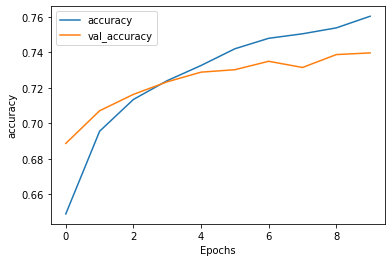

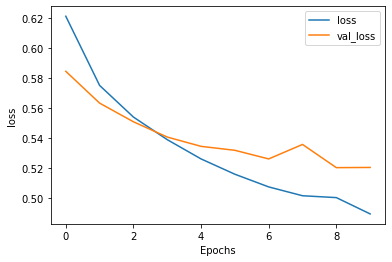

In [24]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Primer grafico: The gap between the training and validation accuracy indicates the amount of overfitting.

### Prediction over validation and matrix of confusion 

[[0.28642082 0.7135791 ]
 [0.81529886 0.1847012 ]
 [0.86407155 0.1359284 ]
 ...
 [0.14613459 0.85386544]
 [0.42712072 0.57287925]
 [0.9583813  0.04161875]]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Train accuracy :0.7604427337646484
Val accuracy :0.73974609375


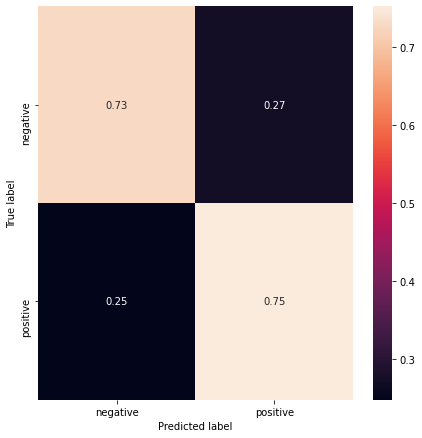

In [25]:
# predict over validation to assess model
y_pred=model.predict(x_val_pad) 
print(y_pred)

y_pred=np.argmax(y_pred,axis=1)

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

print('Train accuracy :' + str(acc[-1]))
print('Val accuracy :' + str(val_acc[-1]))

plot_confussion_matrix(labels = y_val_seq, predictions = y_pred, classes = label_index.keys(), figsize = 6)

### Test on brand new data:

In [26]:
df_test.reset_index(drop=True, inplace=True)

# cleaning text
df_test['text_clean'] = [get_clean_text(t) for t in df_test['text']]

# change labels if not text
print('original label type :' + str(type(df_test.label[0])))
if type(df_test.label[0]) != str:
    df_test.label = df_test.label.astype(str)
    print('label type changed to :' + str(type(df_test.label[0])))

original label type :<class 'str'>


In [27]:
# tokenization and padding
x_test_seq  = tokenizer.texts_to_sequences(df_test['text_clean'].to_list())
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

y_test_seq = np.array(label_tokenizer.texts_to_sequences(df_test['label'].to_list()))

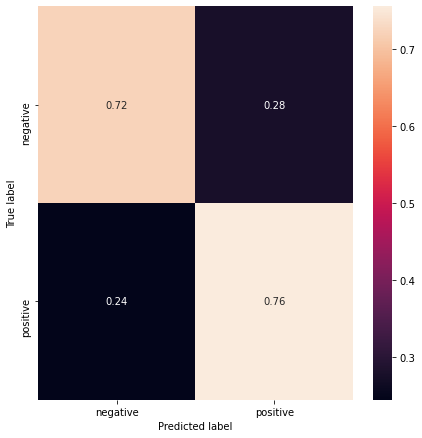

0.73940625

In [28]:
# predict the coming brand new data
y_test_pred=model.predict(x_test_pad) 
y_test_pred=np.argmax(y_test_pred,axis=1)
plot_confussion_matrix(labels = y_test_seq, predictions = y_test_pred, classes = label_index.keys(), figsize = 6)

from sklearn.metrics import accuracy_score

accuracy_score(y_test_seq, y_test_pred)